In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import astropy 
from astropy.cosmology import Planck15 as cosmo
from astropy import constants as astropy_const

from scipy import integrate

import warnings
warnings.filterwarnings('ignore')

# Limber Approximation

Refer to this [paper](https://arxiv.org/pdf/1812.05995.pdf) for Limber Approximation:

$$C_\ell^{a} = \frac{2}{2\ell + 1} \int_0^\infty dk P_\delta(k, z_\ell) \tilde{\Delta}_\ell^a(k)$$ 

where

$$\tilde{\Delta}_\ell^D(k) = p_z(z_\ell)  b(z_\ell)  H(z_\ell)$$

for number density. For each $k$ and $\ell$ define a radial distance $\chi_\ell \equiv (\ell + 1/2) / k$. Then, $$dk = -\frac{1}{\chi_\ell^2} (\ell + 1/2) d\chi_\ell.$$

Thus

$$C_\ell^{D} = \int_0^\infty \frac{d\chi_\ell}{\chi_\ell^2} P_\delta(k, z_\ell)  p_z(z_\ell) b(z_\ell) H(z_\ell)$$ 

where

$$\chi = c \int_a^1 \frac{da'}{a'^2 H(a')} = c \int_a^1 \frac{da'}{a'^2 \sqrt{E(a)^2 H_0^2}},   \frac{d\chi}{da} = - \frac{c}{H_0} \left(\frac{1}{a^2 E(a)}\right)$$

and $$E(a) = \left(\frac{\Omega_m}{a^3} + \frac{\Omega_k}{a^2} + \Omega_{de}\right) = \frac{H(a)^2}{H_0^2}$$

Finally,

$$C_\ell^{D} = \frac{c}{H_0}\int_0^1 \frac{da}{a^2 E(a)} \frac{1}{\chi_\ell^2} P_\delta(k, z_\ell)  p_z(z_\ell) b(z_\ell) H(z_\ell)$$ 

## Helper functions

In [2]:
def a2z(a):
    return 1. / a - 1.

def z2a(z):
    return 1. / (z + 1.)

def Esqr(cosmo, a):
    omega = 1.0 - cosmo.Ok0
    omega_de = omega - cosmo.Om0
    return cosmo.Om0 * np.power(a, -3) + \
            cosmo.Ok0 * np.power(a, -2) + omega_de

def H(cosmo, a):
    return cosmo.H0.value * np.sqrt(Esqr(cosmo, a))

def primordial(k):
    return k ** 0.9667

# Normalized redshift distribution
def pz(z, a=1.0, b=2.0, z0=1.0):
    return 2.0 * z * np.exp(-(z ** b))
    
c = astropy_const.c.to('km/s').value    
rh = c / cosmo.H0.value

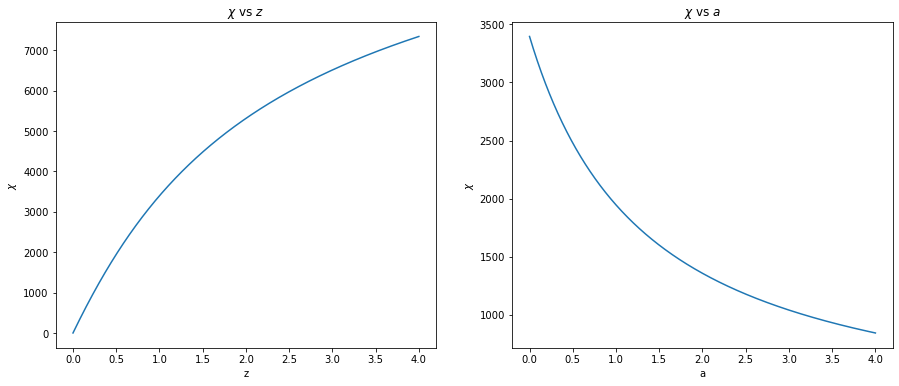

In [3]:
zmin, zmax = 0, 4
nbins = 1023
z = np.linspace(zmin, zmax, nbins+1)
a = z2a(z)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].plot(z, cosmo.comoving_distance(z))
axs[0].set_title('$\chi$ vs $z$')
axs[0].set_xlabel('z')
axs[0].set_ylabel('$\chi$')

axs[1].plot(z, cosmo.comoving_distance(a))
axs[1].set_title('$\chi$ vs $a$')
axs[1].set_xlabel('a')
axs[1].set_ylabel('$\chi$');

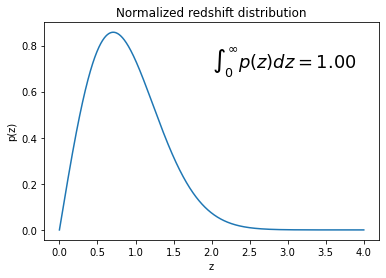

In [4]:
plt.plot(z, pz(z))
plt.title('Normalized redshift distribution')
plt.xlabel('z')
plt.ylabel('p(z)')
text = f'\int_0^\infty p(z)dz={integrate.quad(pz, 0, np.inf)[0]:.2f}'
plt.text(2.0, 0.7, '$%s$' % text, size=18);

## Numpy approximation

In [5]:
def angular_cl(cosmo, ell):
    def cl(ell):
        def integrand(a):
            chi = cosmo.comoving_distance(a2z(a)).value * cosmo.h
            k = (ell + 0.5) / np.clip(chi, 1.0, None)
            pk = primordial(k)
            result = rh * cosmo.h * pk * pz(a2z(a)) * H(cosmo, a) / (a ** 2 * np.sqrt(Esqr(cosmo, a)) * np.clip(chi ** 2, 1.0, None))
            return result
        return integrate.romberg(integrand, z2a(zmax), 1.0) / c ** 2
    return cl(ell)

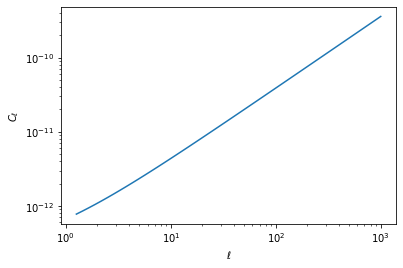

In [6]:
ell = np.logspace(0.1, 3)

cl = []
for l in ell:
    cl.append(angular_cl(cosmo, l))
    
plt.loglog(ell, cl)
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$');

## Compare it with jax-cosmo

In [7]:
import jax
import jax.numpy as jnp
from jax import jit
from jax import lax
from jax import vmap

from functools import partial

from jax_cosmo.angular_cl import _get_cl_ordering
from jax_cosmo.parameters import Planck15
from jax_cosmo.bias import constant_linear_bias
from jax_cosmo.redshift import smail_nz
from jax_cosmo import constants as jax_const
from jax_cosmo import probes
from jax_cosmo import background as bkgrd
from jax_cosmo import power
from jax_cosmo.scipy.integrate import simps

In [8]:
# Code from jax-cosmo but with primordial matter power
def angular_cl_jax(cosmo, ell, probes):
    zmax = max([p.zmax for p in probes])
    @partial(vmap, out_axes=1)
    def cl(ell):
        def integrand(a):
            chi = bkgrd.radial_comoving_distance(cosmo, a)
            k = (ell + 0.5) / jnp.clip(chi, 1.0)
            pk = power.primordial_matter_power(cosmo, k)
            kernels = jnp.vstack([p.kernel(cosmo, a2z(a), ell) for p in probes])
            cl_index = jnp.array(_get_cl_ordering(probes))
            def combine_kernels(inds):
                return kernels[inds[0]] * kernels[inds[1]]
            kernels = lax.map(combine_kernels, cl_index)
            result = pk * kernels * bkgrd.dchioverda(cosmo, a) / jnp.clip(chi ** 2, 1.0)
            return result.T
        return simps(integrand, z2a(zmax), 1.0, 512) / jax_const.c ** 2
    return cl(ell)

In [9]:
cosmo_jax = Planck15()
nz = smail_nz(1.0, 2.0, 1.0)
bias = constant_linear_bias(1.0)

tracer_jax = probes.NumberCounts([nz], bias)
cl_jax = angular_cl_jax(cosmo_jax, ell, [tracer_jax])[0]

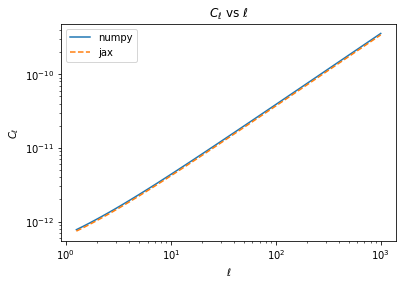

In [10]:
plt.loglog(ell, cl, label='numpy')
plt.loglog(ell, cl_jax, label='jax', ls='--')
plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.title('$C_\ell$ vs $\ell$')
plt.legend();